# Pattern matching


We will start in the same way as the last notebook started  - by downloading/importing the packages needed and importing the .csv file(s) needed. In this case, we only need the .csv file that has the matched abstracts as we are specifically looking at person-first and identity-first patterns that are "about" autism (or ASD, Asperger's syndrome, etc.). 

We could use the same basic approach to look at person-first and identity-first language for other conditions for which there are good noun and adjective forms of the words (diabetes? obesity? cancer? something else?). Doing that would mean using the .csv file with all of the abstracts or potentially creating and entirely new file of abstracts matched to another condition of interest. However, that lies outside the scope of this research, so I will not address it further here. 

## Get ready 

As always, we start with a couple of code cells that load up and nickname some useful packages, then check file locations, then import files and check them. 

In [1]:
%%capture

# installing necessary pdf conversion packages via pip
# the '%%capture' at the top of this cell suppresses the output (which is normally quite long and annoying looking). 
# You can remove or comment it out if you prefer to see the output. 
!pip install nltk
!pip install spacy -q
!python -m spacy download en_core_web_lg -q


In [2]:
%%capture

import os                         # os is a module for navigating your machine (e.g., file directories).
import nltk                       # nltk stands for natural language tool kit and is useful for text-mining. 
from nltk import word_tokenize    # and some of its key functions
from nltk import sent_tokenize  
tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from nltk.corpus import wordnet                    # Finally, things we need for lemmatising!
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
nltk.download('averaged_perceptron_tagger')        # Like a POS-tagger...
nltk.download('wordnet')
nltk.download('webtext')
from nltk.corpus import webtext

import pandas as pd
pd.set_option('display.max_colwidth', 200)
import numpy as np
import statistics

import csv                        # csv is for importing and working with csv files

from collections import Counter

import statistics
import re                         # things we need for RegEx corrections
import string 
import spacy 
from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy 
nlp = spacy.load('en_core_web_lg')
nlp.max_length = 1500000 #or any large value, as long as you don't run out of RAM

import math
import matplotlib.pyplot as plt


In [ ]:
print(os.listdir("..\\output")  )      

## Import

Having checked the contents of the output folder and seen the files we expected to see, we can now import the specific file of interest for this step of the analysis.

In [24]:
matched_texts = pd.read_csv('..\\output\\matched_abstracts_no_null_texts.csv')    # one for just those that match the keyword
len(matched_texts)                                                                # check the length 

3794

## Cleaning phase

Cleaning begins by turning any instances of extra whitespaces (two or more in a row) into a single whitespace. Then, identifying any run-on sentences (where a lowercase letter, a full stop, and an uppercase letter are clustered without a whitespace) and inserting a whitespace between the full stop and the uppercase letter. Both of these steps will improve the sentence tokenisation that happens next. 

Then, we proceed to sentence tokenising the text. Like word tokens, sentence tokens become the unit for analysisis. As a trivial example, sentence tokenisation would turn a short text such as 


''' The cat named Cat is one of five cats. Honestly, I wonder why I have so many cats.
''' 

into a list of sentence tokens like

''' [[The cat named Cat is one of five cats.]

[Honestly, I wonder why I have so many cats.]]

''' 

An important difference is that the punctuation within the sentences that contributes to its structured and meaning (e.g. the comma and the full stops) are retained. This punctuation, like the capitalisation at the start of the sentences or for the poper nouns, is also retained as it helps the sentence-tokenisation process identify the words within the sentence correctly for their parts of speech (e.g. which of the words are nouns, verbs, etc. ). 



The sentence tokens are then put on individual rows, filtered to retain only those that contain one or more of the keywords of interest, and then filtered to ensure that there are no empty rows or duplicates. 

In [25]:
test_string = "Testing.Run-on removal.   Extra whitespace removal. "

def remove_errors (input):
    no_extra_spaces = re.sub(r'(\s)(\s+)', r'\1', input)               # turn 2+ sequential whitespaces into 1
    no_run_ons = re.sub(r'([a-z].)([A-Z])', r'\1 \2', no_extra_spaces) # identifies run-ons (e.g. "word.New sentence ")

    return(no_run_ons)

remove_errors(test_string)

'Testing. Run-on removal. Extra whitespace removal. '

In [26]:
no_run_ons = [remove_errors(abstract) for abstract in matched_texts['Text'] ] 
                                             # create abstract list without extra spaces/run-ons 
                                             # this is to improve sentence tokenisation later 
matched_texts['Sentence'] = no_run_ons       # copy the no extra space/run-on abstract list back into df as a new column

In [27]:
sentences  = [sent_tokenize(abstract) for abstract in matched_texts['Sentence'] ] # create tokenised list of cleaner abstracts
matched_texts['Sentence'] = sentences                                   # copy that list back into df as a new column
sentence_per_row = matched_texts.explode('Sentence')                    # explode column in new df with 1 row/sentence token
len(sentence_per_row)                                                   # check the length of new df


56033

In [ ]:
sentence_per_row                                                    # have a look. For the first two rows, 
                                                                    # 'Text' should be same, but 'Sentence' should not

In [28]:
matched_sentences = sentence_per_row[sentence_per_row['Sentence'].str.contains('[Aa]utis|ASD|AS|[Aa]sperger')]
                                                     # create a new data frame with only the sentences that contain keywords
len(matched_sentences)                               # check the length

7957

In [29]:
matched_sentences = matched_sentences[~matched_sentences['Sentence'].isnull()]  # remove any rows with empty 'Sentence' column
matched_sentences = matched_sentences.drop_duplicates()                         # drop any duplicates
len(matched_sentences)                                                          # check length of remaining data frame

7956

In [30]:
tidy_test = "Autism spectrum intellectual disability and autism ID, ASD Autisticspectrum autisticspectrumdisorder ASD intellectual disability Intellectual Disability (ID)"

def tidy_up_terminology (input):
    space1 = re.sub(r'([a-z])(spec)', r'\1 \2', input)                    # turn 2+ sequential whitespaces into 1
    space2 = re.sub(r'([a-z])(disorder)', r'\1 \2', space1)               # turn 2+ sequential whitespaces into 1
    space3 = re.sub(r'([a-z])(disability)', r'\1 \2', space2)               # turn 2+ sequential whitespaces into 1
    space4 = re.sub(r'(spec) (trum)', r'\1\2', space3)               # turn 2+ sequential whitespaces into 1
    lower1 = re.sub(r'Autis', r'autis', space4)
    lower2 = re.sub(r'[Aa]spergers|[Aa]sperger', r'asperger', lower1)
    lower3 = re.sub(r'[Ss]pectrums|[Ss]pectra', r'spectrum', lower2)
    lower4 = re.sub(r'[Ss]yndromes|[Ss]yndrome', r'syndrome', lower3)
    lower5 = re.sub(r'[Dd]isorders|Disorder', r'disorder', lower4)
    lower6 = re.sub(r'[Dd]iseases|Disease', r'disease', lower5)
    plur1 = re.sub(r'ASDs', r'ASD', lower6)    
    AS1 = re.sub(r'(autism|asperger) (syndrome|spectrum) \(AS\)', r'autism', plur1)
    AS2 = re.sub(r'asperger autism', r'autism', AS1)
    ASD1 = re.sub(r'autism spectrum disorder \(ASD\)', r'ASD', AS2)   # turn 2+ sequential whitespaces into 1
    ASD2 = re.sub(r'(autistic|autism) disorder', r'ASD', ASD1)
    ASD3 = re.sub(r'(autistic|autism) spectrum disorder', r'ASD', ASD2)
    ASD4 = re.sub(r'(autistic|autism) spectrum', r'ASD', ASD3)
    ASD5 = re.sub(r'(autism|autistic) disease', r'autism', ASD4)
    ID1 = re.sub(r'[Ii]ntellectual [Dd]isability \(ID\)', r'ID', ASD5)
    ID2 = re.sub(r'[Ii]ntellectual [Dd]isability', r'ID', ID1)
    ID3 = re.sub(r'(ID and )(autism|ASD)', r'\2', ID2)
    ID4 = re.sub(r'(ID, )(autism|ASD)', r'\2', ID3)

    return(ID4)

tidy_up_terminology(tidy_test)


### NOTE TO SELF  -
# asperger autism to autism




'ASD autism ASD ASD ASD ASD ID ID'

In [31]:
tidy_text = [tidy_up_terminology(sentence) for sentence in matched_sentences['Sentence'] ] 
                                             # create abstract list without extra spaces/run-ons 
                                             # this is to improve sentence tokenisation later 
matched_sentences['Sentence'] = tidy_text    # copy the no extra space/run-on abstract list back into df as a new column

In [32]:
backup = matched_sentences                    # A backup is useful at this step because the next may not go the way you expect

In [51]:
matched_sentences = backup                  # If you need the backup, re-run this step. 

## Extraction

Following the cleaning phase, we move on to the extraction phase. This has two parts, first for the person-first extraction and then for the identity-first extraction. 

The results of both extractions are saved in their own column to make it easy to read and also to allow for a single sentence-token to contain both kinds of patterns. 

### Person-first pattern

In [52]:
pattern_1 = [{"POS": "NOUN"},                                        # define the person-first pattern - start with a noun
             {'DEP':'amod', 'OP':"?"},                               # followed by an optional modifier
             {"TEXT": {"REGEX": "(with|by|from)"}},                  # followed by some words that set up the p-f pattern
             {'DEP':'amod', 'OP':"?"},                               # then space for up to three optional modifiers
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"TEXT": {"REGEX": "(^[Aa]utis|^[Aa]sperger|^ASD|^AS)"}}]   # finally, the keywords

# Matcher class object 
matcher = Matcher(nlp.vocab)                                         # define a matcher class object
matcher.add("matching_1", [pattern_1])                               # add my three person-first patterns to it


In [53]:
def find_pattern_match(input):                                               # define a function that applies the person-first
    thingy = nlp(input)                                                       # matcher class object to strings
    match = matcher(thingy)                                                   # and returns any matches to the pattern(s)
    if match == []:
        out_value = ''
    else:
        hold_multi_spans = []
        for match_id, start, end in match:
                string_id = nlp.vocab.strings[match_id]  # Get string representation
                span = thingy[start:end]  # The matched span
                hold_multi_spans.append(span)
        out_value = hold_multi_spans
    return out_value

In [54]:
matched_sentences['Person-first'] = matched_sentences.apply(lambda row: find_pattern_match(row.Sentence), axis = 1)
                                                                        # apply the newly defined person-first matcher function
                                                                        # and store the returned output in a new column
len(matched_sentences)                                                  # double check length remains same

7956

### Identity-first pattern

In [55]:
pattern_a = [{'DEP':'amod', 'OP':"?"},                                 # same for identity-first patterns,
             {'DEP':'amod', 'OP':"?"},                                 # starting with two optional modifiers
             {"TEXT": {"REGEX": "(^[Aa]utis|^[Aa]sperger|^ASD|^AS)"}},     # then the keywords
             {'DEP':'amod', 'OP':"?"},                                 # then upt to three more optional modifiers
             {'DEP':'amod', 'OP':"?"},
             {'DEP':'amod', 'OP':"?"},
             {"POS": "NOUN"}]                                          # and then a noun

# Matcher class object                                         
matcher = Matcher(nlp.vocab) 
matcher.add("matching_2", [pattern_a])            # this overwrites the matcher object to identity-first

In [56]:
matched_sentences['Identity-first'] = matched_sentences.apply(lambda row: find_pattern_match(row.Sentence), axis = 1)
                                                                        # apply the newly overwritten matcher function
                                                                        # and store the returned output in a new column
len(matched_sentences)                                                  # check the length - why not?

7956

### Consolidation

Following the cleaning and extraction phases, the last phase is consolidation. This phase further refines the data by removing all the rows that do not contain a match for one or both of the patterns. For example, there would be a row for "The child was tested for autism." because it contains a keyword of interest. However, this sentence would be eliminated in the consolidation phase as the keyword does not fit into either the person-first or identity-first patterns. 

Further, this phase goes on to lemmatise the extracted patterns so that they can be counted more easily. This phase also lowercases all occurrences of "Autistic", "Autism", and "Asperger's" as well as removing the apostrophe, the 's' and any non-white characters that might intrude between the 'r' and the 's' of "Asperger's". This phase also removes any square brackets, quotes and extra commas introduced by the lemmatisation process. 

This phase ends by writing out the consolidated data frame to a .csv for manual inspection. I could not find a feasible way of identifying whether or not the nouns matched in the extraction phase are person-nouns or not. As the list is not a totally unreasonable length (in the hundreds) I found it workable to 
* open in excel, 
* save the file under another name (e.g. pattern_matches_reviewed), 
* order the entire data set alphabetically by 'Person-first', 
* scan through the ordered results check whether each result in the 'Person-first' column is about a person, 
* removing entire rows if the 'Person-first' match is not about a person (checking the 'Sentence' or 'Text' column if needed)
* re-order the entire data set alphabetically by 'Identity-first', 
* scan through the ordered results check whether each result in the 'Identity-first' column is about a person, 
* removing entire rows if the 'Identity-first' match is not about a person, 
* save file again. 

For example, 'association with autism' matches the person-first pattern but is not about a person, so this row was removed. Many more rows were removed in the 'Identity-first' matches as things like 'autistic behaviours' and 'autism testing' were removed for not being about people. 

NOTE: There were several instances of "ASD dataset" which are not easy to determine if they are about people or not. Do they mean dataset composed from blood tests taken as part of ASD testing? If so, each row in the data set would be a blood test with the possibility that more than one test comes from the same person. Or do they mean a pool of case records, each of which represents a single person? The former would not be "about people" but the second would. I did not remove these rows as we cannot be certain. Leaving them out would also have been a valid option, as long as the choice was clear. 

Coincidentally, during this manual checking part of the consolidation phase I learned that, in the context of human genetics research "proband" is a person-noun. 

In [57]:
matched_patterns = matched_sentences[(matched_sentences['Person-first'] != '') | (matched_sentences['Identity-first'] != '')]
                                                     # keep only rows w/ non-null 'Person-first' and/or 'Identity-first' columns
len(matched_patterns)                                # check length

1040

In [58]:
matched_patterns = matched_patterns.explode('Person-first')    # explode 'Person-first' column to create 1 row per match
                                                               # if there were two matches within the same sentence
len(matched_patterns)                                          # check the length

1042

In [59]:
matched_patterns = matched_patterns.explode('Identity-first')  # Do the same for 'Identity-first' column
len(matched_patterns)                                          # check the length

1142

In [45]:
matched_patterns                                               # have a look at them

,Unnamed: 0,Title,Session_Code,Authors_and_Affiliations,Text,Year,Email,Author,Affiliations,Sentence,Person-first,Identity-first
8,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,autism was first described in 1944 by a Viennese physi cian Hans asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with some modifications.,"(boys, with, autistic)","(autistic, psychopa)"
8,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,In the pediatric age group the prevalence of asperger syndrome is around 4 7/1000 whereas the corresponding figurefor the infantile autism is 4/10000.,,"(asperger, syndrome)"
23,443,Preliminary Findings In The Diagnostic Evaluation Of A Sample Of 103 Individuals With Pervasive DevelopmentDisorders,P0341.,E. Steiner M. M. Guerreiro A. P. Marques de Faria Unicamp Campinas B,Pervasive development disorders (PDD) are a heterogeneous group ofneurobehavioral disorders of infancy. In order to identify etiologic factors ina sample of individuals with PDD a total of 103 su...,2001.0,dgmfcm@unicamp.br,NaN,NaN,In order to identify etiologic factors ina sample of individuals with PDD a total of 103 subjects (84 males and 19females) referred for autistic behavior were submitted to a protocol includ ing c...,,"(autistic, behavior)"
26,473,Detection of subtelomeric rearrangements by FISH in patients with idiopathic mental retardation or autism.,P0372.,Ostergaard J. M. Hahnemann H. Hjalgrim K. Nielsen H. M. Nielsen K. Brondum NielsenJohn F. Kennedy Institute Glostrup D,The subtelomeric regions are often involved in chromosomal rearrange 172 Posters: Clinical Genetics and Dysmorphologyments. They are gene rich and therefore rearrangements in these regions are mor...,2001.0,els@kennedy.dk,NaN,NaN,Two groups of patients all with normal standard chromosome analysis were investigated One group consisted of 14 patients with autism andwith at least one other relative affected with autism.,"(patients, with, autism)",
31,571,Rett Syndrome Phenotype Expansion and Broaden ing Parameters for Diagnosis and DNA Testing ResultingFrom the Availability of Mutation Analysis.,P0483.,R. Shapiro1 2 H. G. Taska2 R. V. Scott2 D. F. Kronn1 2 1New York Medical College Valhalla NY United States 2Westchester Medical Center Valhalla NY United S,The diagnosis of Rett Syndrome prior to the availability of mutation analy sis by sequencing the MECP2 gene was based on rigid clinical criteria females who had normal development until 6 18 month...,2001.0,lrskicker@msn.com,NaN,NaN,The diagnosis of Rett syndrome prior to the availability of mutation analy sis by sequencing the MECP2 gene was based on rigid clinical criteria females who had normal development until 6 18 mo...,,"(autistic, behavior)"
...,...,...,...,...,...,...,...,...,...,...,...,...
3738,409,NaN,NaN,NaN,"S424 , at Xq23-24 in one family with cryptogenic epilepsy. affected male members presented with non-speciÜc MR and Objective: practically healthy boy at 10 years stopped in psychomotor verbal d...",2004.0,NaN,NaN,NaN,A

In [60]:
Lem = WordNetLemmatizer()                         # Define a short way to call the WordNetLemmatizer

In [61]:
def consolidate_matched_patterns (input):         # 
    final_lemma_list = []
    temp_lemma_list = []
    for phrase in input:                       # start for loop looking at each pattern in the person-first pattern column
        phrase_as_string = str(phrase)                               # hold the current pattern
        words_in_phrase = phrase_as_string.split() # split the current pattern into words
        for word in words_in_phrase :                            # for each word in the split up words
            lemma = Lem.lemmatize(word)             # turn that word into a lemma
            temp_lemma_list.append(lemma)                # append that lemma to a temporary list
        string_lem = str(temp_lemma_list)              # turn that temporary list into a string
        stripped_lem = re.sub(r"\[|\]|\'|\,",'', string_lem)  # remove  square brackets, commas and '' marks from the string
        lower_autis = re.sub(r'Autis', r'autis', stripped_lem)               # lowercases Autism or Autistic
        lower_asp = re.sub(r'Asperger', r'asperger', lower_autis)          # lowercases Asperger
        no_apost = re.sub(r'(asperger[\S*?]s)', r'asperger', lower_asp)    # Removes any apostrophe and non-whitespace in asperger's
        no_s = re.sub(r'(aspergers)', r'asperger', no_apost)               # Removes any s following asperger 
                                                                       # also removes any 's or s after asperger
        final_lemma_list.append(no_s)        # append the string version of the list to the output list
        temp_lemma_list = []                               # ensure the temp variable is empty

    return(final_lemma_list)


In [62]:
person_lemma_list = consolidate_matched_patterns(matched_patterns['Person-first'])
identity_lemma_list = consolidate_matched_patterns(matched_patterns['Identity-first'])


In [63]:
matched_patterns['Person-first'] = person_lemma_list    # copy the person-first output to new column in data frame 
matched_patterns['Identity-first'] = identity_lemma_list  # copy the identity-first output to new column in data frame 
matched_patterns = matched_patterns.drop_duplicates()                         # drop any duplicates
matched_patterns                                                   # have a look at the data frame with its new columns

,Unnamed: 0,Title,Session_Code,Authors_and_Affiliations,Text,Year,Email,Author,Affiliations,Sentence,Person-first,Identity-first
8,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,autism was first described in 1944 by a Viennese physi cian Hans asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with some modifications.,boy with autistic,autistic psychopa
8,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,In the pediatric age group the prevalence of asperger syndrome is around 4 7/1000 whereas the corresponding figurefor the infantile autism is 4/10000.,,asperger syndrome
8,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,We report the analysis of13 candidate gene loci associated with autism and schizophrenia in 17Finnish AS families with autosomal dominant mode of inheritance.,,AS family
8,150,Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,C102.,E. Jarvela1 T. Ylisaukko oja2 T. Nieminen3 E. Kempas1 M. Auranen1 L. Peltonen1 1National Public Health Institute Helsinki Finland 2National Public Health Insitute Helsinki Finland 3Uni...,Asperger syndrome (AS) was first described in 1944 by a Viennese physi cian Hans Asperger who reported a group of boys with autistic psychopa thy whose clinical features resembled autism with som...,2001.0,irma.jarvela@hus.fi,NaN,NaN,Linkageto the previously reported predisposing loci for autism could not be repli cated with Finnish AS families.,,AS family
14,296,Fluorescence In Situ Hybridization (FISH) signal pat terns in Chronic Myeloid Leukaemia(CML) and Acute Lym phoblastic Leukaemia (ALL) patients in Singapore using ES FISH BCR ABL Probe,P0169.,L. Tien1 C. Siwaswaren2 P. Lim2 E. Lim2 1Singapore General Hospital Singapore 169608 Singapore 2Singapore General Hospital Singapore S,We used Vysis LSI bcr/abl extra signal (ES) translocation probe to studyFISH signal patterns in CML and ALL patients in Singapore General Hos pital. From 1999 to 2000 we studied 51 consecutive CML...,2001.0,ghetsl@sgh.com.sg,NaN,NaN,From 1999 to 2000 we studied 51 consecutive CML cases and found12 cases (23.5%) with deletion of ASS region giving 1R1G1F signal 1 ofwhich had small deletion of ASS region giving 1R1dim R1G1F s...,,ASS region
...,...,...,...,...,...,...,...,...,...,...,...,...
3776,1710,NaN,NaN,NaN,P0697How to prepare stable reference materials for genetic establish that treatment of cultured human dermal Übroblasts with testing several recombinant Übrillin-1 fragments induces up-regulatio...,2004.0,NaN,NaN,NaN,stable trans

In [64]:
matched_patterns.to_csv('..\\output\\pattern_matches_to_review.csv')        
                                                            # Write the data frame to a .csv for manual processing in excel

At this point, I open the file in Excel (for example), removed the brackets, quotation marks and commas in the Person-first lemmatised and Identity-first lemmatised columns, then sort by each of one of these columns. I then scan through the results, removing any rows that are obviously not about people (e.g. "autistic testing") and checking the 'Text' column on any that are unclear 'autistic quartets'). I then sort by the other column and repeat the step of reviewing and deleting non-person rows. Save under "pattern_matches_reviewed.csv" for the next step. 

## Chart person-first or identity-first by year

In [65]:
reviewed_matches = pd.read_csv('..\\output\\pattern_matches_reviewed.csv')    # one for just those that match the keyword
print(len(reviewed_matches)  )


432


In [66]:
total_unique_abstracts = reviewed_matches['Title'].nunique()
print(total_unique_abstracts)

229


In [67]:
reviewed_matches

,Unnamed: 0.1,Unnamed: 0,Title,Session_Code,Authors_and_Affiliations,Text,Year,Email,Author,Affiliations,Sentence,Person-first,Identity-first
0,1504,728,The association analysis of ABHD11 gene (rs2293484 and rs10279013 with autism in a South African population.,P06.05,NaN,"Background : Autism is genetically inherited neurodevelopmental disorder characterized by significant impairments of social interaction, difficulties in communication and displays of restrictive o...",2013,NaN,"Z. Arieff1, J. R. Sharma1, M. Davids1, M. Kaur2","1Department of Biotechnogy,University of Western Cape, Private Bag X17, Bellville 7535, South Africa, South Africa, 2Computational Bioscience Research Center, King Abdullah University of Science...",Aims : The aim of this study was to investigate the association of two SNPs from genes ABHD11 (rs2293484 and rs10279013) in South African autistic population.,NaN,African autistic population
1,1811,905,MThe Haplotype analysis to test for the association of three SNPs with autism in a South African Population,P09.152,NaN,Autism spectrum disorder is a neuropsychiatric developmental disorder characterized by communication difficulties and impaired social interac tion. The anhydrolase domain containing 11 gene (ABHD1...,2014,NaN,"Z. Arieff1, J. R. Sharma1, M. Davids1, M. Kaur2","1Department of Biotechnology, University of Western Cape, Bellville, South Africa, 2Computational Bioscience Research Center, King Abdullah University of Science and Technology, Thuwal, Saudi Ar...",The aim of this study was to investigate the association of SNPs from genes ABHD11 (rs2293484 and rs10279013) and ABHD13 (rs17060) with haplotype ana lysis in South African autistic population.,NaN,African autistic population
2,483,863,Angelman syndrome caused by an identical familial 1487 kb deletion,P0728.,NaN,"Angelman syndrome (AS, OMIM#105830) is a neurodevelopmental disorder characterized by mental retardation, ataxia, hypotonia, epi lepsy, absence of speech, and specific facial features. At least...",2007,NaN,"Matsumoto1,2, M. Iwakoshi3","1Yokohama City University, Yokohama, Japan, 2SORST, Japan Science and Technology Agency (JST), Kawaguchi, Japan, 3Nishinomiya Municipal Wakaba en, Nishinomiya, Japan","We encountered a similar family with an atypical microdeletion, con sisting of an AS boy later confirmed, and asymptomatic mother and maternal grandfather.",NaN,AS boy
3,78,1534,Alstrom syndrome report of a family and exclusion of rab 1 and rhotekin as candidate genes,P1597.,Titomanlio1 M. Sperandeo2 1 D. De Brasi1 M. Sibilio1 A. Pepe1 G. Andria1 G. Sebastio1 1Department of Pediatrics Federico II University Naples Italy 2Telethon Foundation Rome I,Main features of Alstrom syndrome (MIM 203800 AS) include pigmentaryretinal dystrophy obesity non insulin dependent diabetes mellitus and414 Posters: Molecular Basis of Mendelian Disorderssenso...,2001,talyltitomanlio@libero.it,NaN,NaN,We observed two AS brothers born to non consanguineous healthy parents.,NaN,AS brother
4,131,2305,Molecular genetic analysis of autosomal dominant Andria1 G. Sebastio1 polycystic kidney disease in Czech families 1Department of Pediatrics Federico II University Naples Italy 2Telethon,P1595.,Stekrova1 J. Reiterova2 M. Kohoutova2 J. Zidovska1 J. Kapras2 M. Foundation Rome Italy Merta2,1General Teaching Hospital of 1st Faculty of Medicine Charles University Main features of Alstrom syndrome (MIM 203800 AS) include pigmentary Prague Czech Republic 21st Faculty of Medicine ...,2001,ltitomanlio@libero.it,NaN,NaN,We observed two AS brothers born to non consanguineous healthy parents.,NaN,AS brother
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,3306,117,"Systematic evaluation of prenatal and pediatricdiagnostic yields from whole genome sequencing in 8,954 individuals",C08.4,NaN,"J. L. Giordano3, V. S. Aggarwal4, H. Z. Whang1, X. Zhao1,2, D. Lucente1, L. Margolin2, D. M. Werling5, J. Y. An5, S. Dong5, S. J. Sanders5, B. Devlin6, K. Gilmore7, B. Powell8, A. 

In [68]:
person_first = reviewed_matches[~reviewed_matches['Person-first'].isnull()]
person_first['Year'] = person_first['Year'].astype('Int64')
len(person_first)

C:\Users\mzyssjkc\AppData\Local\Temp\ipykernel_19632\2098205386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person_first['Year'] = person_first['Year'].astype('Int64')


138

In [89]:
print(person_first['Person-first'][0:100])

181    proband affected from ASD
182          patient with autism
183            child with autism
190             autistic proband
191            child with autism
                 ...            
389          patient with autism
390          patient with autism
391          patient with autism
392          patient with autism
393          patient with autism
Name: Person-first, Length: 100, dtype: object


In [69]:
identity_first = reviewed_matches[~reviewed_matches['Identity-first'].isnull()]
identity_first['Year'] = identity_first['Year'].astype('Int64')
len(identity_first)

C:\Users\mzyssjkc\AppData\Local\Temp\ipykernel_19632\2854974618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identity_first['Year'] = identity_first['Year'].astype('Int64')


298

In [70]:
person_count = person_first.groupby(['Year'])['Person-first'].count()
identity_count = identity_first.groupby(['Year'])['Identity-first'].count()

In [71]:
person_identity_count=pd.concat([person_count,identity_count],axis=1)
person_identity_count = person_identity_count.fillna(0)
person_identity_count = person_identity_count.sort_index()


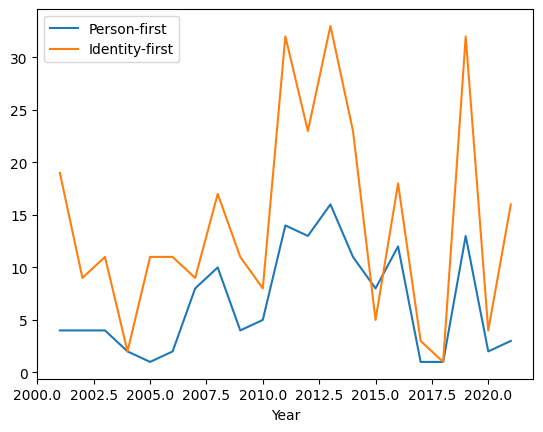

<Figure size 640x480 with 0 Axes>

In [72]:
person_identity_count.plot()
plt.show()
plt.savefig('..\\output\\matches_count.jpg')    # we can right click on the plot above to save it, or save it via command

In [73]:
person_examples = reviewed_matches.groupby(['Person-first'])['Person-first'].count()
identity_examples = reviewed_matches.groupby(['Identity-first'])['Identity-first'].count()
print(len(person_examples))
print(len(identity_examples))

44
70


In [74]:
person_identity_examples=pd.concat([person_examples,identity_examples],axis=1)


In [90]:
person_identity_examples.sort_values(by=['Person-first'], ascending=False).head(100)

,Person-first,Identity-first
patient with autism,32.0,NaN
child with autism,18.0,NaN
patient with ASD,16.0,NaN
individual with ASD,9.0,NaN
individual with autism,6.0,NaN
...,...,...
autistic group,NaN,6.0
autistic individual,NaN,12.0
autistic patient,NaN,22.0
autistic population,NaN,6.0


In [76]:
person_identity_examples.sort_values(by=['Identity-first'], ascending=False).head(10)

,Person-first,Identity-first
AS patient,NaN,45.0
ASD patient,NaN,33.0
autistic patient,NaN,22.0
autistic child,NaN,14.0
autism patient,NaN,14.0
autistic individual,NaN,12.0
ASD case,NaN,12.0
AS case,NaN,11.0
ASD family,NaN,10.0
AS family,NaN,9.0


In [77]:
person_identity_examples.notnull().sum()

Person-first      44
Identity-first    70
dtype: int64

## Count abstracts by the structures they use

In [78]:
person_by_title = reviewed_matches.groupby(['Title'])['Person-first'].count()
identity_by_title = reviewed_matches.groupby(['Title'])['Identity-first'].count()
title = pd.concat([person_by_title,identity_by_title],axis=1)
title

,Person-first,Identity-first
Title,,
16p11.2 microdeletion and microduplication in two Lithuanian patients with speech delay,0,1
20 ans aprÃ¨s: a second family with mutation in X linked monoamine oxidase A gene affecting cognition and behavior,1,0
"2p25 deletion: involvement of SNTG2 in autism or behavioral troubles, and parental imprinting.",0,1
8p rearrangements detected by array CGH in a 1500 cohort of patients with intellectual disability,1,0
A c GH Array study in non syndromic (primary) autism disorder,1,3
...,...,...
multiple minor congenital defects associated with autism spectrum disorders,2,2
"scanning copy number variations (cNV) in Angelman syndrome, mental retardation and autism",0,2
sleep and its disturbances in Angelman syndrome,0,1


In [79]:
title.sort_values(by=['Identity-first'], ascending=False)

,Person-first,Identity-first
Title,,
Role of serotonin transporter promoter length polymorphism in autism: A south African population based study,0,9
B Evidence for altered calcium signaling and altered mitochondrial function in an autism case study,0,6
Unexpectedly low prevalence of HLA B27 in Romanian ankylosing spondylitis patients,0,5
D Evaluation of targeted sequencing as the ï¬rst tier genetic test for intellectual disability and autismspectrum disorders diagnosis,0,5
Polymorphism in Serotonin Transporter Gene in Autism,1,5
...,...,...
S A novel mutation in KAT6B in a patient with genitopatellar syndrome and some features of SBBYSS,1,0
"S Chromosomal microarray analysis of patients with intellectual disability, autism or multiple congenital anomalies presenting for genetic services",1,0
Gene expression analysis in autism using cDNA microarrays,1,0


In [80]:
title.sort_values(by=['Person-first'], ascending=False)

,Person-first,Identity-first
Title,,
Autism s pectrum Disorders and s eizure s yndrome,4,2
c hildren autism and mitochondrial DNA mutations,4,0
A 2.2mb microduplication in 1q42.2 including DISC in 2 brothers with autism and mild mental retardation,3,0
"HDAC1: a novel cause of autism, developmental delay and epilepsy",3,0
Additional evidence to support the role of the 20q13.33 region in susceptibility to autism,3,0
...,...,...
"A Complex cases with Autism Spectrum Disorder (ASD), developmental delay, hyperactivity and sleep distur bance explained by oligogenic mechanisms Maria Cerminara 1, Martina Servetti1,2, Margherita Squillario2, Livia Pisciotta1,3, Giovanni Spirito4,5, Maria Teresa Divizia2, Margherita Lerone2, Elisa De Grandis1,6, Silvia Boeri6, Lino Nobili1,6, Diego Vozzi5, Remo Sanges4,5, Federico Zara1,2, Stefano Gustincich5, Aldamaria Puliti1,2 1Department of Neurosciences, Rehabil itation, Ophthalmology, Genetics, Maternal and Child Health (DiNOGMI ), University of Genova, Genova, Italy,2Medical Genetics Unit, IRCCS Istituto Giannina Gaslini, Genova, Italy,3Child Neuropsychiatry Unit, ASST Fatebenefratelli Sacco, Milano, Italy,4Area of Neuroscience, Scuola Int ernazionale Superiore di Studi Avanzati (SISSA), Trieste, Italy,5Department of Neuroscience and Brain Technologies, Istituto Italiano di Tecnologia (IIT), Genova, Italy,6Child Neuropsychiatry Unit, IRCCS Istituto Giannina Gaslini, Genova, Italy",0,3
A Delineation of the phenotypic and genotypic spectrum of type IV collagen related nephropathy Alport syndrome and thin basement membrane nephropathy Korbinian M,0,2
A Establishing genotype phenotype associations for ASD,0,1


In [81]:
columns = ['Person-first','Identity-first']
filter_ = (title[columns] > 0).all(axis=1)
title[filter_]
len(title[filter_])


31

In [82]:
title[filter_].sort_values(by=['Person-first'], ascending=False)

,Person-first,Identity-first
Title,,
Autism s pectrum Disorders and s eizure s yndrome,4,2
B MLPA analysis as a diagnostic test in patients withautism spectrum disorders,3,2
multiple minor congenital defects associated with autism spectrum disorders,2,2
Cytogenetic analysis in autistic disorder,2,2
M Array Comparative Genome Hybridization (aCGH) in children with autistic spectrum phenotype,2,2
Frequency of mosaic aneuploidy in children with idiopathic autism,2,1
Two cases with different microaberrations of the long arm of chromosome 15 and autism,2,1
Microrrearrangements of human chromosome 15q11 q13 in families with autistic disorder,1,4
Genome linkage analysis using affected sibling pairs for autism,1,1


In [83]:
title[filter_].sort_values(by=['Identity-first'], ascending=False)

,Person-first,Identity-first
Title,,
Polymorphism in Serotonin Transporter Gene in Autism,1,5
Abnormal growth and dysmorphic features in children with autism spectrum disorders,1,4
Microrrearrangements of human chromosome 15q11 q13 in families with autistic disorder,1,4
A c GH Array study in non syndromic (primary) autism disorder,1,3
Contribution of rare and common variants of the PTCHD1 gene to Autism Spectrum Disorder and Intellectual Disability,1,3
No evidence for an association with the serotonin transporter gene polymorphisms (5 HTTVNTR and 5 HTTLPR) and autism,1,3
cADHERiN 11 as a possible candidate gene for autism,1,2
Location of the first predisposing gene locus for Asperger syndrome on chromosome 1q21 22,1,2
Frequent 22q11 aberrations in patients with non syndromic autism spectrum disorders shown by sNP array based segmental aneuploidy screening,1,2


In [84]:
has_pf = title[title['Person-first'] > 0]
has_both = has_pf[has_pf['Identity-first'] > 0]
print(len(has_both))
has_both

31


,Person-first,Identity-first
Title,,
A c GH Array study in non syndromic (primary) autism disorder,1,3
Autism s pectrum Disorders and s eizure s yndrome,4,2
Contribution of rare and common variants of the PTCHD1 gene to Autism Spectrum Disorder and Intellectual Disability,1,3
Cytogenetic analysis in autistic disorder,2,2
Genetic causes of pervasive developmental disorders,1,1
Identifying phenotypes and exploring genetic aetiology of autism spectrum disorders : a 87 patient study.,1,1
Inherited and de novo SHANK2 variants associated with autism spectrum disorder impair neuronal morphogenesis and physiology,1,1
M Array Comparative Genome Hybridization (aCGH) in children with autistic spectrum phenotype,2,2
S No evidence for a contribution of CHRNA7 rare variants in autism susceptibility,1,1
